In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model...use 'automap_base()' to reflect the tables into classes
Base = automap_base()

# reflect the tables...Base.prepare method
Base.prepare(engine, reflect=True)

In [7]:
# We can view all of the classes that automap found (station & measurement)
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)
conn = engine.connect()

# Exploratory Climate Analysis

In [10]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results

# Calculate the date 1 year ago from the last data point in the database (get the last date)
# Latest date in the database
last_date = session.query(func.max(Measurement.date)).scalar()
last_date

'2017-08-23'

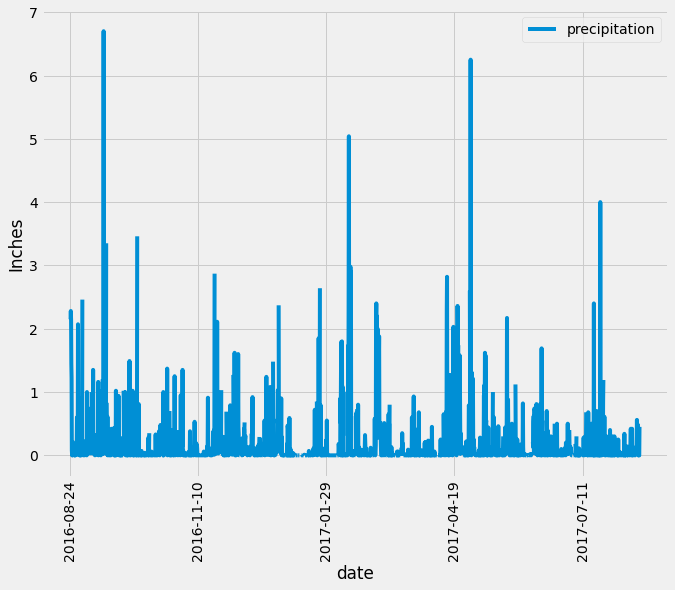

<Figure size 432x288 with 0 Axes>

In [11]:
# Perform a query to retrieve the data and precipitation scores...
query_date = dt.datetime.strptime(last_date, '%Y-%m-%d') - dt.timedelta(days=365)

# generate a query OBJECT
last_year = session.query(Measurement.date, Measurement.prcp).\
    filter(Measurement.date >= query_date).all()

# Save the query results as a Pandas DataFrame and set the index to the date column
precip_df = pd.DataFrame(last_year)
precip_df.set_index('date', inplace=True)

#Rename the "prcp" column into 'precipiation' 
precip_df.rename(columns = {'prcp':'precipitation'}, inplace = True)

# Sort the dataframe by date
precip_df.sort_index(inplace=True)

# Use Pandas Plotting with Matplotlib to plot the data
ax1 = precip_df.plot(figsize=(10,8))

plt.xticks(rotation = 'vertical')
plt.ylabel('Inches')
plt.show()

#Save as png
plt.savefig('Images/precipitation_data.png')

In [12]:
# Use Pandas to calcualte the summary statistics for the precipitation data
precip_df.describe()

,precipitation
count,2015.000000
mean,0.176462
std,0.460288
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [13]:
# Design a query to show how many stations are available in this dataset?
stations = session.query(Station.station).\
        group_by(Station.station).count()
print(f'Total number of stations: {stations}')

Total number of stations: 9


In [14]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
most_active_stations = session.query(Measurement.station, func.count(Measurement.station)).\
    filter(Station.station == Measurement.station).group_by(Measurement.station).\
    order_by(func.count(Station.station).desc()).all()
print(f'These stations that have the most rows:')
most_active_stations

These stations that have the most rows:


[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [15]:
print(f'''
    The station with the highest number of observations is: USC00519281
''')


    The station with the highest number of observations is: USC00519281



In [16]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?
temperatures = session.query(func.min(Measurement.tobs), func.max(Measurement.tobs),\
                              func.avg(Measurement.tobs)).filter(Measurement.station == 'USC00519281').first()


print(f'''
        The Lowest Temperature recored is: 54
        The Highest Temerature recorded is: 85
        The Average Temperature is: 71.66378066378067
        ''')
temperatures


        The Lowest Temperature recored is: 54
        The Highest Temerature recorded is: 85
        The Average Temperature is: 71.66378066378067
        


(54.0, 85.0, 71.66378066378067)

In [17]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
tobs = pd.read_sql("SELECT tobs FROM measurement where \
    station = 'USC00519281' AND date >= DATE('2017-08-23', '-12 months')", conn)
# tobs

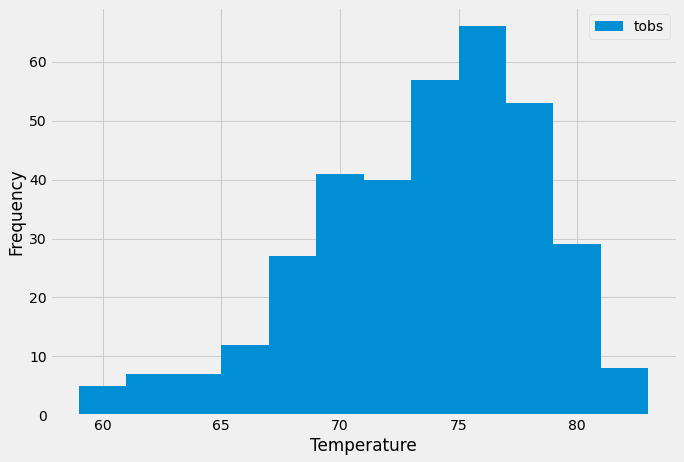

In [18]:
num_bins = 12
fig, ax = plt.subplots(figsize=(10,7))

n, bins, patches = ax.hist(tobs['tobs'], num_bins)
ax.set_ylabel('Frequency')
ax.set_xlabel('Temperature')
ax.legend(['tobs'],loc='best')

plt.savefig('Images/Histogram.png')
plt.show()

## Bonus Challenge Assignment

In [19]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2017-01-01', '2018-01-01'))

[(58.0, 74.14387974230493, 87.0)]


In [20]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
min_avg_max = calc_temps('2016-01-01', '2017-01-01')
min_avg_max

[(56.0, 74.1317494600432, 84.0)]

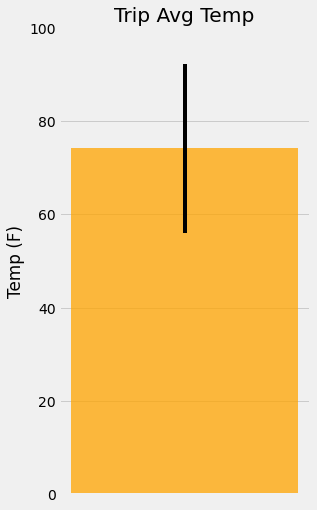

<Figure size 432x288 with 0 Axes>

In [21]:
 # Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)

min = min_avg_max[0][1]
avg = min_avg_max[0][1]
max = min_avg_max[0][0]

min_error = avg - min
max_error = max - avg

plt.figure(figsize=(4,8))
plt.bar(0, avg, yerr=[max - min], color = 'orange', alpha=.75)
plt.title('Trip Avg Temp')
plt.ylabel('Temp (F)')
plt.xticks([])
plt.ylim(0,100)

plt.show()
plt.savefig("Resources/temp.png")

In [22]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation



OperationalError: (sqlite3.OperationalError) near "BU": syntax error
[SQL: SELECT s.station,s.name,s.latitude,s.longitude,s.elevation,sum(m.prcp) as 'Total Rainfaill'                        FROM station s                        JOIN measurement m ON(s.station = m.station)                        WHERE m.date BETWEEN '2016-01-01' AND '2017-01-01'                        GROUP BY s.station                        ORDER BU SUM(m.prcp) DESC]
(Background on this error at: http://sqlalche.me/e/13/e3q8)

In [ ]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

In [23]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date


In [ ]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index


In [ ]:
# Plot the daily normals as an area plot with `stacked=False`
